# Forecasting using Facebook's Prophet package

## Introduction:

Forecasting is a fundamental data science task. Accurate forecasting is crucial when planning and allocating resources, setting goals and detecting anomalies. However, building reliable and robust forecasting models is challenging and often requires expert input. For example, there may be holidays or other 'one-off' effects that need to be taken in consideration for accurate forecasts. 

In this short tutorial we will provide an overview forecasting and discuss how to quickly implement your own forecast using the Prophet package recently released by Facebook Core Data Science team. The Prophet package fits an easily interpretable regression model which can account for seasonality trends (e.g., yearly or weekly effects) and holiday effects

Throughout this tutorial we will be using an open access TFL dataset relating to the number of TFL cycles borrowed over a period of several years. This dataset will demonstrate considerable season effects (for example there are yearly seasonal effects as customers are likely to cycle in the summer) as well as and holiday effects (in particular, we will study the effects of bank holidays and the tube strike on the number of bikes borrowed!). This dataset will demonstrate considerable season effects (i.e., more likely to cycle in the summer) as well as trend and holiday effects. 

Before discussing the details of the prophet package, we provide an exploratory overview of the dataset.

## Getting started

In order to get started, you will need to install the Prophet package. Simply use the following command on Mac and Linux:

```
pip install fbprophet
```

For Windows, follow the instructions from [this thread on the official development repository](https://github.com/facebook/prophet/issues/2#issuecomment-296321790).

In [1]:
# import modules:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import os

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

## The dataset

The dataset we will study corresponds to the total number of daily hires for Santander bikes over a period of approximately seven years. You can download the TFL cycle hire dataset from the following website: https://data.london.gov.uk/dataset/number-bicycle-hires

In [3]:
# load in dataset:
# Modify the directory name to the one you placed the dataset in
#os.chdir('/somewhere/there/or/here/Data')
dat = pd.read_excel('data/tfl-daily-cycle-hires.xls', sheetname='Data')

# we are only interested in the first two columns
dat = dat[ [u'Day', u'Number of Bicycle Hires']]
dat.head()

/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,Day,Number of Bicycle Hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


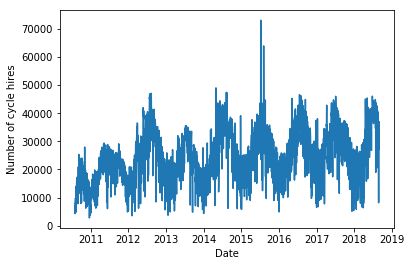

In [4]:
plt.plot( dat['Day'], dat['Number of Bicycle Hires'])
plt.xlabel('Date')
plt.ylabel('Number of cycle hires')
plt.show()

From the figure above (of daily bike hires) we see several clear effects which are often present in forecasting challenges:

1. Seasonality: There is a drop during the winter months and a rise during the summer months. This seasonality is easy to understand but needs to be accounted for in order to obtain reliable forecasts.
2. Trends: There is a slight, overall upward trend. This means that the number of cycles hired has increased over time. 
3. Outliers: There are obvious outliers, notably during the summer of 2015. This coincides with the tube strike, which foreced commuters to find alternative routes. The histogram plot, shown below, highlights the presence of these large positive outliers. 
 
In the remainder of this tutorial we will introduce the prophet package and demonstrate how it may be used to handle each of the challenges discussed above. 

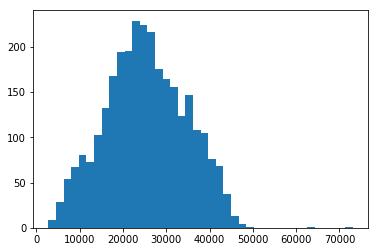

In [5]:
# Histrogram of the data to demonstrate there are large positive outliers.
# It is important to note that due to the seasonality, there may also be large 
# negative outliers, but we cannot spot them in the histogram below as 
# they are within the range of the data. 
#
# the data appears to be approximately Gaussian, with a few outliers (we discuss these below).
# so don't need to transform the data (e.g., via log transform)
plt.hist((dat['Number of Bicycle Hires']), bins=40)
plt.show()

## The Prophet model

The idea behind the prophet package is to decompose time series data into the following three components:

- trends: these are non-periodic and systematic trends in the data,
- seasonal effects: these are modelled as daily or yearly periodicities in the data (optionally also hourly), and
- holiday/one-off effects: these are effectively outliers.
 
Each of these components contribute *additively* to the observed time series. In other words, the number of cycle hires on any give day is *the sum* of the trend component, the seasonal component and the one-off effects. As a result, the model can be mathematically written as follows:

$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$

where $y(t)$ is the number of cycles hired on day $t$ and $g(t), s(t)$ and $h(t)$ correspond to the growth trend, seasonal effects and holiday effects respectively. Finally, $\epsilon_t$ accounts for noise. 

We note that the approach taken in the Prophet packge is different from traditional forecasting models such as [ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) models. For example, note that $y(t)$ is not a function of $y(t-1)$ but instead a function of the growth, season and holiday effects. The main advantages of taking an additive approach are as follows.

- It provides us with more flexibility. For example, we can easily accomodate irregular measurements.
- We can directly interpret each of the additive components and thus untangle the contributions of each aspect to the forecasts. This is important when we look to understand how the data was generated.
 
We now discuss each of the components of the model

### Trend component

The default trend component in the Prophet package is a linear growth trend with some changepoints. If there are no changepoints, this means that the growth with continue to grow at some linear rate such that:

$$ g(t) = \alpha t$$

Changepoints are introduced so that the linear rate of growth can vary. For example, it may be the case that there was 2% daily growth (corresponding to $g(t) = 1.02 \times t$) for the first year and 1% daily growth (so that $g(t) = 1.01 \times t$) afterwards.

### Seasonal components

Seasonality is a crucial component of many time-series and is clearly present in the TFL data we study here. The approach taken in the Prophet package is to consider various seasonal components with varying periodicities. For example, we may have one component with a periodicity of 7 days to capture weekly effects, and another with a periodicity of 365 days to capture yearly effects. By default, the Prophet package includes weekly and yearly seasonalities. This is what makes the most sense in this example, but it is also possible to include other seasonalities.

### Holidays/outliers 

Finally, a well-document difficulty with time-series and forecasting data is the presence of outliers. These are data points which deviate significantly from the distribution of the remainder of the data. If these points are ignored they may possibly lead to poor forecasts and so it is important to consider these points carefully. Recall that in the case of the TFL cycle hire data, there were clear outliers around the time of the 2015 strikes (around the summer of 2015). Other important examples may include holidays or snow days.

The Prophet package directly allows for such events by allowing the user to input a list of days which were holidays or potential outliers. The holiday component to the model is then:

$$
h(t) =
\begin{cases}
\kappa & \mbox{if $t$ is a holiday/outlier}\\
0 & \mbox{otherwise}
\end{cases}
$$

In this way the scalar $\kappa$ accounts for large positive/negative values of holidays or potential outliers.

## Fitting the model
Now that we have the data ready as well as a high-level understanding of the forecasting model we will use, we are ready to fit our model!

Before we begin, we must make sure we prepare the data in a correct format. We also need to prepare a `DataFrame` with holidays and the dates of the tube strikes.

In [6]:
# The prophet package expects input as a dataframe with the first column indicating time and 
# the second indicating the time series we wish to forecast

dat['Day'] = pd.DatetimeIndex( dat['Day'] )

# It also expects these columns to have the names 'ds' and 'y', so we rename them accordingly
dat = dat.rename(columns={'Day': 'ds', 'Number of Bicycle Hires': 'y'}) 
dat.head()

,ds,y
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


In [ ]:
# Following our discussion, we add a set of outliers/holidays for our Prophet model.
# we make a separate DataFrame for bank holidays and for tube strikes

# We get the list of bank holidays from the following csv file:

bank_holidays = pd.DataFrame({
    'holiday': 'BankHoliday',
    'ds'     : pd.to_datetime( list(pd.read_csv('data/BankHolidayLists.csv')['Date']) )
})

strike_days = pd.DataFrame({
    'holiday': 'strike',
    'ds'     : pd.to_datetime( ['2017-08-05', '2017-08-06', '2017-02-06', '2015-07-09', '2015-07-08', '2015-03-08'] )
})


all_holidays_strikes = pd.concat( (bank_holidays, strike_days) )
all_holidays_strikes.tail(n=10)

In [ ]:
# now we are ready to fit a forecast model with prophet
forecast_model = Prophet( growth='linear',  weekly_seasonality=3, yearly_seasonality=3, holidays=all_holidays_strikes )
forecast_model.fit( dat )

## Interpreting and understanding the model

Now that we have build our forecasting model, we can interogate the model to understand what it is doing. 
The first way to do this is to see how the model fits existing data and what a forecast over 1 year looks like. This is shown below. From this plot we notice the model has done a good job of picking up the yearly seasonality.

In [ ]:
# we can now study the fit of the model - in order to do so, we need to creat another df
df_dates = forecast_model.make_future_dataframe(periods=365, 
                                                include_history=True)
model_predictions = forecast_model.predict( df_dates )
plot_pred = forecast_model.plot( model_predictions )
plt.legend(loc='best', fontsize=20)
plot_pred

<span style="color:blue">
In the plot above, the black dots correspond to the observed number of cycles hired each day (you'll notice that we don't have data beyond the beginning of 2018!). The dark blue line (labeled 'yhat') corresponds to the estimated number of cycles based on the estimated model. We notice it does a good job of capturing the main sources of variability in the data. Finally, the light blue lines correspond to the 80% confidence interval for the models predictions.
</span>

To get an even further understanding of the model, we can plot each of the model components. This is shown below. 

In the top panel we see the linear growth term. Recall that this term contained changepoints so that the rate of growth was allowed to vary over time. We notice that there is a large positive trend from around late 2010 until mid 2012. This is the initial adoption period. Then we notice a slight drop during 2013 before the trend stabilises. 

The second panel shows the effect of holidays and and tube strikes. The holidays have negative effects whilst the tube strikes have a positive effects. This suggests that the bikes are used for commuting.

The final two panels show the estimated yearly and weekly trends of the model. As expected there is a large increase during the summer months when the weather is more pleasant. In the case of the weekly trend, we notice that there is a large drop during weekends. This also suggests that bikes are used for commuting.

In [ ]:
# we can also study the model components - this allows us to further understand the data we study
#
# we notice the following:
# initial trend during 2011-2013 which levels off (there appears to be a dip in summer of 2013, its unclear why)
# clear yearly seasonlity with a peak in the summer and drop in winter
# also a clear weekly seasonality - it seems the bikes are used mostly during the week (presumably for commuting) than on weekends
# Finally, we note that bank holidays lead to a fall in the usage of the bikes, while the days of the strikes lead to significant increases!

forecast_model.plot_components( forecast_model.predict(df_dates), 
                               uncertainty=False )

<span style="color:blue">
**Note**: Finally, you may have noticed that the weekly plot appears as if it is continuous valued when we would expect it to be discrete (i.e., one value per day). Intuitively, it makes sense to fit the weekly component as an individual parameter per day of the week. This would result in a discrete weekly component, but it also requires us to estimate 7 parameters (one for each day of the week). This might not be the best way to procede. </span>

<span style="color:blue">
In the case of the Prophet package, a slightly different approach is employed. Instead of estimate a parameter for each day as discussed above, the instead employ a [fourier series](https://en.wikipedia.org/wiki/Fourier_series) to model the daily effects. This effectively uses a periodic function to predict the number of cycles hired where the period is carefully adjusted to 7 days. For further details, see Section 3.2 of the [Prophet paper](http://amstat.tandfonline.com/doi/abs/10.1080/00031305.2017.1380080#.WoFjRpPFLdQ). 
</span>

Congratulations on fitting your forecasting model using the Prophet package! If you are interested in learning more about the underlying models and how they are estimated, you can find many more resources on the official Prophet website:

https://research.fb.com/prophet-forecasting-at-scale/

and the official starting guide on Github:

https://facebook.github.io/prophet/docs/quick_start.html#python-api

If you more interested in the model details and estimation, you can read the paper associated with the package here:

https://peerj.com/preprints/3190.pdf